### homework1：完成DNN，bn，selu，dropout等调参实战

DNN实战

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


加载数据

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# fashion_mnist图像分类数据集
train_ds = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_ds = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

In [3]:
from torchvision.transforms import Normalize


# 定义一个函数 `cal_mean_std`，用于计算数据集中所有图像的每个通道的均值和标准差
def cal_mean_std(ds):
    mean = 0.  # 初始化均值为0
    std = 0.  # 初始化标准差为0

    # 遍历数据集中的每张图片和对应的标签
    for img, _ in ds:  # img.shape=[1,28,28]，表示单通道的28x28图像
        mean += img.mean(dim=(1, 2))  # 计算当前图像的均值，dim=(1, 2)表示在高度和宽度维度上求均值
        std += img.std(dim=(1, 2))  # 计算当前图像的标准差，dim=(1, 2)表示在高度和宽度维度上求标准差

    mean /= len(ds)  # 计算所有图像的平均均值
    std /= len(ds)  # 计算所有图像的平均标准差

    return mean, std  # 返回计算得到的均值和标准差


# 调用 `cal_mean_std` 函数计算训练数据集 `train_ds` 的均值和标准差
print(cal_mean_std(train_ds))  # 输出结果为 (0.2860, 0.3205)

# 使用计算得到的均值和标准差创建一个归一化变换
transforms = nn.Sequential(
    Normalize([0.2860], [0.3205])  # 这里的均值和标准差是通过 `train_ds` 计算得到的
)

(tensor([0.2860]), tensor([0.3205]))


定义模型

这里我们没有用`nn.Linear`的默认初始化，而是采用了xavier均匀分布去初始化全连接层的权重

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, layers_num=2):
        super().__init__()
        self.transforms = transforms  # 预处理层，用于标准化输入数据
        self.flatten = nn.Flatten()  # 展平层，将输入的多维张量展平为一维
        # 定义神经网络的主体结构
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 100),  # 第一层全连接层，输入维度为 28*28，输出维度为 100
            nn.ReLU(),  # ReLU 激活函数
        )
        # 动态添加更多的全连接层
        for i in range(1, layers_num):
            self.linear_relu_stack.add_module(f"Linear_{i}", nn.Linear(100, 100))  # 添加全连接层
            self.linear_relu_stack.add_module(f"relu", nn.ReLU())  # 添加 ReLU 激活函数
        # 输出层
        self.linear_relu_stack.add_module("Output Layer", nn.Linear(100, 10))  # 输出层，输出维度为 10（对应 10 个类别）

        # 初始化权重
        self.init_weights()

    def init_weights(self):

        """使用 xavier 均匀分布来初始化全连接层的权重 W"""
        # print('''初始化权重''')
        for m in self.modules():  # 遍历模型中的所有模块
            if isinstance(m, nn.Linear):  # 判断当前模块是否为全连接层
                nn.init.xavier_uniform_(m.weight)  # 使用 Xavier 均匀分布初始化权重
                nn.init.zeros_(m.bias)  # 使用全零初始化偏置项
        # print('''初始化权重完成''')

    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        x = self.transforms(x)  # 对输入数据进行标准化
        x = self.flatten(x)  # 将输入数据展平为一维向量
        # 展平后 x.shape [batch size, 28 * 28]
        logits = self.linear_relu_stack(x)  # 通过全连接层和激活函数
        # logits.shape [batch size, 10]
        return logits


total = 0
# named_parameters()：返回模型的所有参数（权重和偏置项）及其名称。
# np.prod(value.shape)：计算当前参数的形状中所有维度的乘积，即当前参数的元素个数。
for idx, (key, value) in enumerate(NeuralNetwork(20).named_parameters()):
    total += np.prod(value.shape)  # 计算当前参数的元素个数并累加
total  # 输出模型的总参数数量

np.int64(271410)

In [7]:
# 创建一个未初始化的 3x5 的张量 w
w = torch.empty(3, 5)  # 创建一个形状为 (3, 5) 的张量，其值是未初始化的（可能是任意值）
print(w)  # 打印未初始化的张量 w

tensor([[-6.5444e-02,  1.7460e-42,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])


In [8]:
# 使用 nn.init.eye_ 对张量 w 进行初始化
nn.init.eye_(w)  # 将张量 w 初始化为单位矩阵（对角线为 1，其余为 0）
print(w)  # 打印初始化后的张量 w

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])


训练

In [9]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)  # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [10]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [11]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [12]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [13]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict


epoch = 100

model = NeuralNetwork(layers_num=10)

In [14]:
# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 1. tensorboard 可视化
tensorboard_callback = TensorBoardCallback("runs")
tensorboard_callback.draw_model(model, [1, 28, 28])
# 2. save best
save_ckpt_callback = SaveCheckpointsCallback("checkpoints", save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10, min_delta=0.001)

model = model.to(device)

In [15]:
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
)

  0%|          | 0/375000 [00:00<?, ?it/s]

Early stop at epoch 24 / global_step 90000


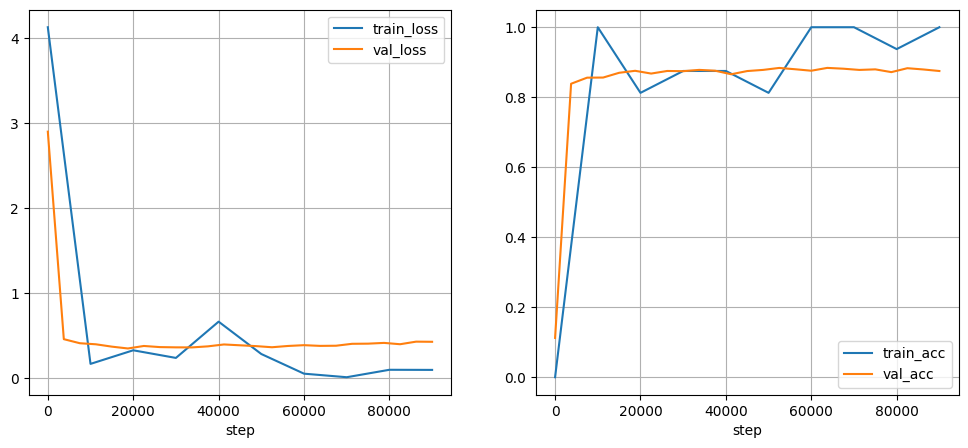

In [16]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(6 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=10000)  #横坐标是 steps

In [17]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/best.ckpt", weights_only=True, map_location="cpu"))

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.4013
accuracy: 0.8796


DNN+bn实战

加载数据

In [18]:
# fashion_mnist图像分类数据集
train_ds = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_ds = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

In [19]:
# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std


# print(cal_mean_std(train_ds))
# 0.2860， 0.3205
transforms = nn.Sequential(
    Normalize([0.2860], [0.3205])
)

定义模型

批归一化（Batch Normalization）的公式可以表示为以下形式：  
给定输入$x$和批数据$\mathcal{B}=\{x_1, x_2, \cdots, x_m\}$，批归一化的计算步骤如下：  
1.计算批数据$\mathcal{B}$的均值$\mu_\mathcal{B}$和方差$\sigma_\mathcal{B}^2$：  
\begin{align*}
\mu_\mathcal{B} &= \frac{1}{m} \sum_{i=1}^m x_i \\
\sigma_\mathcal{B}^2 &= \frac{1}{m} \sum_{i=1}^m (x_i - \mu_\mathcal{B})^2 \\
\end{align*}
2.归一化：  
\begin{align*}
\hat{x}_i &= \frac{x_i - \mu_\mathcal{B}}{\sqrt{\sigma_\mathcal{B}^2 + \epsilon}} \\
\end{align*}
其中，$\epsilon$是一个很小的常数，用于数值稳定性  
3.缩放和移位：  
\begin{align*}
y_i &= \gamma \hat{x}_i + \beta
\end{align*}
其中，$\gamma$是缩放因子（scale factor），$\beta$是移位因子（shift factor），是可学习的模型参数，用于控制输出的分布和均值。  

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self, layers_num=2):
        super().__init__()
        self.transforms = transforms  # 预处理层，用于标准化输入数据
        self.flatten = nn.Flatten()  # 展平层，将输入的多维张量展平为一维
        # 定义神经网络的主体结构
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 100),  # 第一层全连接层，输入维度为 28*28，输出维度为 100
            nn.BatchNorm1d(100),  # 批量归一化层，特征维度为 100
            nn.ReLU(),  # ReLU 激活函数
        )
        # 动态添加更多的全连接层
        for i in range(1, layers_num):
            self.linear_relu_stack.add_module(f"Linear_{i}", nn.Linear(100, 100))  # 添加全连接层
            self.linear_relu_stack.add_module(f"batchnorm_{i}", nn.BatchNorm1d(100))  # 添加批量归一化层
            self.linear_relu_stack.add_module(f"relu", nn.ReLU())  # 添加 ReLU 激活函数
        # 输出层
        self.linear_relu_stack.add_module("Output Layer", nn.Linear(100, 10))  # 输出层，输出维度为 10（对应 10 个类别）

        # 初始化权重
        self.init_weights()

    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层的权重 W"""
        for m in self.modules():  # 遍历模型中的所有模块
            if isinstance(m, nn.Linear):  # 判断当前模块是否为全连接层
                nn.init.xavier_uniform_(m.weight)  # 使用 Xavier 均匀分布初始化权重
                nn.init.zeros_(m.bias)  # 使用全零初始化偏置项

    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        x = self.transforms(x)  # 对输入数据进行标准化
        x = self.flatten(x)  # 将输入数据展平为一维向量
        # 展平后 x.shape [batch size, 28 * 28]
        logits = self.linear_relu_stack(x)  # 通过全连接层、批量归一化层和激活函数
        # logits.shape [batch size, 10]
        return logits


print(f"{'layer_name':^40}\tparamerters num")
total_params = 0
for idx, (key, value) in enumerate(NeuralNetwork(20).named_parameters()):
    print("{}{:<40}\t{:^10}".format(idx, key, np.prod(value.shape)))  # 打印每层的名称和参数数量
    total_params += np.prod(value.shape)  # 累加每层的参数数量
total_params  # 输出模型的总参数数量

               layer_name               	paramerters num
0linear_relu_stack.0.weight              	  78400   
1linear_relu_stack.0.bias                	   100    
2linear_relu_stack.1.weight              	   100    
3linear_relu_stack.1.bias                	   100    
4linear_relu_stack.Linear_1.weight       	  10000   
5linear_relu_stack.Linear_1.bias         	   100    
6linear_relu_stack.batchnorm_1.weight    	   100    
7linear_relu_stack.batchnorm_1.bias      	   100    
8linear_relu_stack.Linear_2.weight       	  10000   
9linear_relu_stack.Linear_2.bias         	   100    
10linear_relu_stack.batchnorm_2.weight    	   100    
11linear_relu_stack.batchnorm_2.bias      	   100    
12linear_relu_stack.Linear_3.weight       	  10000   
13linear_relu_stack.Linear_3.bias         	   100    
14linear_relu_stack.batchnorm_3.weight    	   100    
15linear_relu_stack.batchnorm_3.bias      	   100    
16linear_relu_stack.Linear_4.weight       	  10000   
17linear_relu_stack.Linear_4.bias  

np.int64(275410)

训练

In [21]:
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)  # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [22]:
class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [23]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)  #makedirs 创建多层目录

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [24]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [25]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict


epoch = 100

# 别 20 层了 2333，太深了没法训练
model = NeuralNetwork(layers_num=10)

In [26]:
# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 1. tensorboard 可视化
tensorboard_callback = TensorBoardCallback("runs/bn")
tensorboard_callback.draw_model(model, [1, 28, 28])
# 2. save best
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/bn", save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10, min_delta=0.001)

model = model.to(device)

In [27]:
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
)

  0%|          | 0/375000 [00:00<?, ?it/s]

Early stop at epoch 34 / global_step 127500


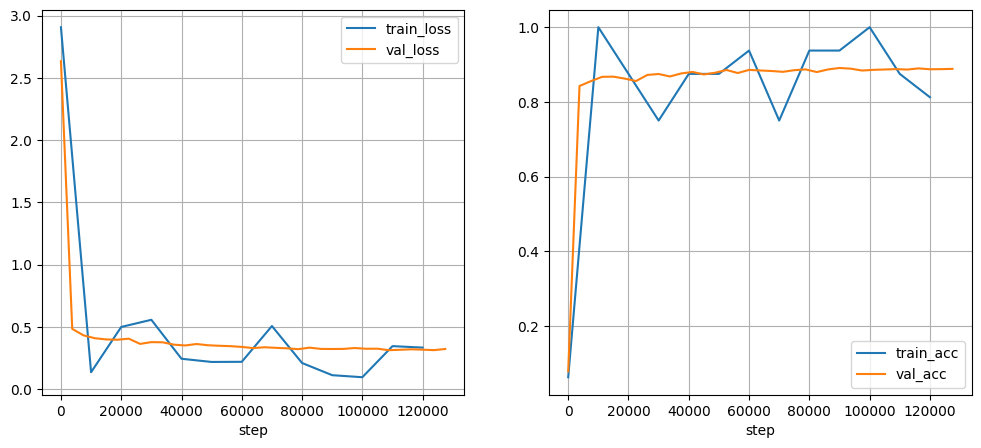

In [28]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(6 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=10000)  #横坐标是 steps

In [29]:
# dataload for evaluating
model = model.to(device)
# load checkpoints
model.load_state_dict(torch.load("checkpoints/bn/best.ckpt", weights_only=True, map_location="cpu"))

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3226
accuracy: 0.8908


DNN+selu实战

加载数据

In [30]:
# fashion_mnist图像分类数据集
train_ds = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_ds = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

In [31]:
# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std


print(cal_mean_std(train_ds))
# 0.2860， 0.3205
transforms = nn.Sequential(
    Normalize([0.2860], [0.3205])
)

(tensor([0.2860]), tensor([0.3205]))


定义模型

In [32]:
class NeuralNetwork(nn.Module):
    def __init__(self, layers_num=2):
        super().__init__()
        self.transforms = transforms  # 预处理层，用于标准化输入数据
        self.flatten = nn.Flatten()  # 展平层，将输入的多维张量展平为一维
        # 定义神经网络的主体结构
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 100),  # 第一层全连接层，输入维度为 28*28，输出维度为 100
            nn.SELU(),  # SELU 激活函数
        )
        # 动态添加更多的全连接层
        for i in range(1, layers_num):
            self.linear_relu_stack.add_module(f"Linear_{i}", nn.Linear(100, 100))  # 添加全连接层
            self.linear_relu_stack.add_module(f"selu", nn.SELU())  # 添加 SELU 激活函数
        # 输出层
        self.linear_relu_stack.add_module("Output Layer", nn.Linear(100, 10))  # 输出层，输出维度为 10（对应 10 个类别）

        # 初始化权重
        self.init_weights()

    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层的权重 W"""
        for m in self.modules():  # 遍历模型中的所有模块
            if isinstance(m, nn.Linear):  # 判断当前模块是否为全连接层
                nn.init.xavier_uniform_(m.weight)  # 使用 Xavier 均匀分布初始化权重
                nn.init.zeros_(m.bias)  # 使用全零初始化偏置项

    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        x = self.transforms(x)  # 对输入数据进行标准化
        x = self.flatten(x)  # 将输入数据展平为一维向量
        # 展平后 x.shape [batch size, 28 * 28]
        logits = self.linear_relu_stack(x)  # 通过全连接层和 SELU 激活函数
        # logits.shape [batch size, 10]
        return logits

    for idx, (key, value) in enumerate(NeuralNetwork(20).named_parameters()):
        print(f"Linear_{idx // 2:>02}\tparamerters num: {np.prod(value.shape)}")

Linear_00	paramerters num: 78400
Linear_00	paramerters num: 100
Linear_01	paramerters num: 100
Linear_01	paramerters num: 100
Linear_02	paramerters num: 10000
Linear_02	paramerters num: 100
Linear_03	paramerters num: 100
Linear_03	paramerters num: 100
Linear_04	paramerters num: 10000
Linear_04	paramerters num: 100
Linear_05	paramerters num: 100
Linear_05	paramerters num: 100
Linear_06	paramerters num: 10000
Linear_06	paramerters num: 100
Linear_07	paramerters num: 100
Linear_07	paramerters num: 100
Linear_08	paramerters num: 10000
Linear_08	paramerters num: 100
Linear_09	paramerters num: 100
Linear_09	paramerters num: 100
Linear_10	paramerters num: 10000
Linear_10	paramerters num: 100
Linear_11	paramerters num: 100
Linear_11	paramerters num: 100
Linear_12	paramerters num: 10000
Linear_12	paramerters num: 100
Linear_13	paramerters num: 100
Linear_13	paramerters num: 100
Linear_14	paramerters num: 10000
Linear_14	paramerters num: 100
Linear_15	paramerters num: 100
Linear_15	paramerters n

训练

In [33]:
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)  # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [34]:
class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [35]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [36]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [37]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict


epoch = 100

model = NeuralNetwork(layers_num=10)

In [38]:

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 1. tensorboard 可视化
tensorboard_callback = TensorBoardCallback("runs/selu")
tensorboard_callback.draw_model(model, [1, 28, 28])
# 2. save best
if not os.path.exists("checkpoints/selu"):
    #创建多级目录
    os.makedirs("checkpoints/selu")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/selu", save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10, min_delta=0.001)

model = model.to(device)

In [39]:
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
)

  0%|          | 0/375000 [00:00<?, ?it/s]

Early stop at epoch 35 / global_step 131250


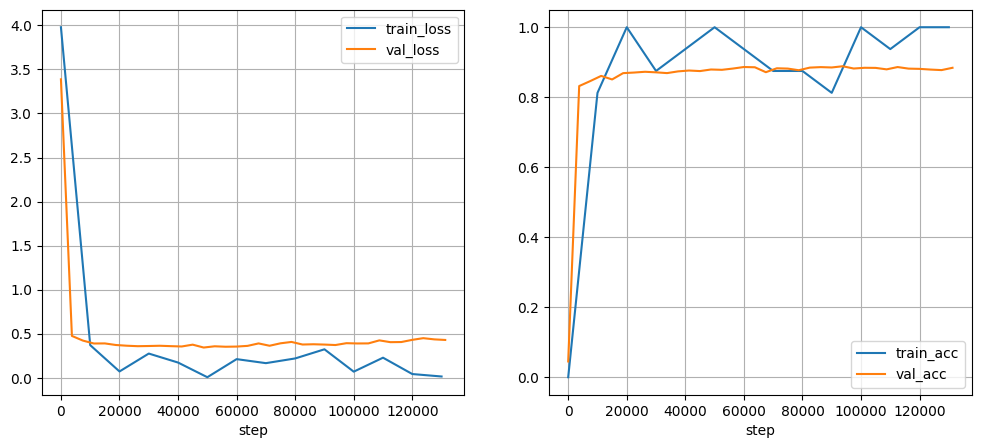

In [40]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(6 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=10000)  #横坐标是 steps

In [41]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/selu/best.ckpt", weights_only=True, map_location="cpu"))

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3541
accuracy: 0.8863


DNN+selu+dropout实战

加载数据

In [65]:
# fashion_mnist图像分类数据集
train_ds = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_ds = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

In [66]:
# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std


# print(cal_mean_std(train_ds))
# 0.2860， 0.3205
transforms = nn.Sequential(
    Normalize([0.2860], [0.3205])
)

定义模型

AlphaDropout：一种特殊的 Dropout，适用于 SELU 激活函数。它在训练时以概率 p 随机将某些神经元的输出置为 0，同时保持输入数据的均值和方差不变。

In [67]:
class NeuralNetwork(nn.Module):
    def __init__(self, layers_num=2, dropout_layers=None):
        super().__init__()
        self.transforms = transforms  # 预处理层，用于标准化输入数据
        self.flatten = nn.Flatten()  # 展平层，将输入的多维张量展平为一维
        # 定义神经网络的主体结构
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 100),  # 第一层全连接层，输入维度为 28*28，输出维度为 100
            nn.ReLU(),  # ReLU 激活函数
        )
        
        # 如果指定在第一层添加 Dropout
        if dropout_layers is not None and 0 in dropout_layers:
            self.linear_relu_stack.add_module("dropout_0", nn.AlphaDropout(p=0.2))
        
        # 动态添加更多的全连接层
        for i in range(1, layers_num):
            self.linear_relu_stack.add_module(f"Linear_{i}", nn.Linear(100, 100))  # 添加全连接层
            self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())  # 添加 ReLU 激活函数
            
            # 如果指定在当前层添加 Dropout
            if dropout_layers is not None and i in dropout_layers:
                self.linear_relu_stack.add_module(f"dropout_{i}", nn.AlphaDropout(p=0.2))
        
        # 输出层
        self.linear_relu_stack.add_module("Output Layer", nn.Linear(100, 10))  # 输出层，输出维度为 10（对应 10 个类别）

        # 初始化权重
        self.init_weights()

    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层的权重 W"""
        for m in self.modules():  # 遍历模型中的所有模块
            if isinstance(m, nn.Linear):  # 判断当前模块是否为全连接层
                nn.init.xavier_uniform_(m.weight)  # 使用 Xavier 均匀分布初始化权重
                nn.init.zeros_(m.bias)  # 使用全零初始化偏置项

    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        x = self.transforms(x)  # 对输入数据进行标准化
        x = self.flatten(x)  # 将输入数据展平为一维向量
        # 展平后 x.shape [batch size, 28 * 28]
        logits = self.linear_relu_stack(x)  # 通过全连接层、ReLU 激活函数和 AlphaDropout 正则化层
        # logits.shape [batch size, 10]
        return logits

    print(f"{'layer_name':^40}\tparamerters num")
    for idx, (key, value) in enumerate(NeuralNetwork(20).named_parameters()):
        print("{:<40}\t{:^10}".format(key, np.prod(value.shape)))

               layer_name               	paramerters num
linear_relu_stack.0.weight              	  78400   
linear_relu_stack.0.bias                	   100    
linear_relu_stack.Linear_1.weight       	  10000   
linear_relu_stack.Linear_1.bias         	   100    
linear_relu_stack.Linear_2.weight       	  10000   
linear_relu_stack.Linear_2.bias         	   100    
linear_relu_stack.Linear_3.weight       	  10000   
linear_relu_stack.Linear_3.bias         	   100    
linear_relu_stack.Linear_4.weight       	  10000   
linear_relu_stack.Linear_4.bias         	   100    
linear_relu_stack.Linear_5.weight       	  10000   
linear_relu_stack.Linear_5.bias         	   100    
linear_relu_stack.Linear_6.weight       	  10000   
linear_relu_stack.Linear_6.bias         	   100    
linear_relu_stack.Linear_7.weight       	  10000   
linear_relu_stack.Linear_7.bias         	   100    
linear_relu_stack.Linear_8.weight       	  10000   
linear_relu_stack.Linear_8.bias         	   100    
linear_

训练

In [68]:
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)  # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [69]:
class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [70]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [71]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [72]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict


epoch = 100
# 在部分层添加 Dropout
model = NeuralNetwork(layers_num=10, dropout_layers=[0, 2, 4, 6, 8])

In [73]:
# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 1. tensorboard 可视化
tensorboard_callback = TensorBoardCallback("runs/dropout")
tensorboard_callback.draw_model(model, [1, 28, 28])
# 2. save best
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/dropout", save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10, min_delta=0.001)

model = model.to(device)

In [74]:
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
)

  0%|          | 0/375000 [00:00<?, ?it/s]

Early stop at epoch 84 / global_step 315000


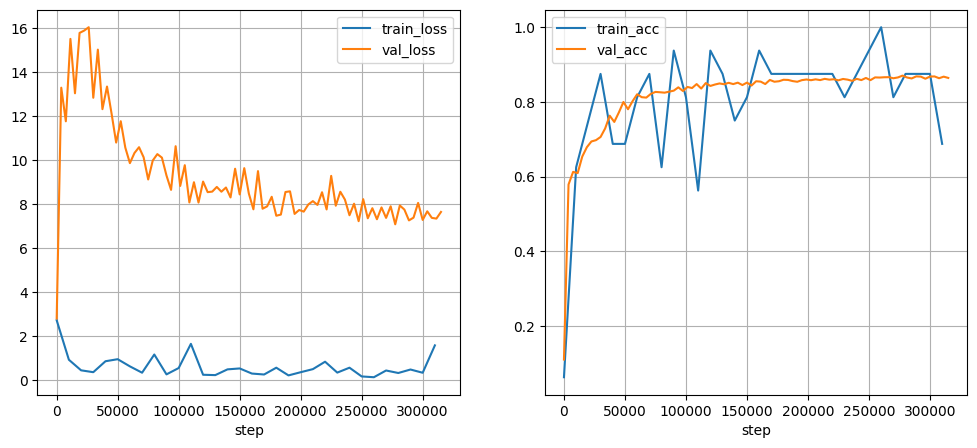

In [75]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(6 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=10000)  #横坐标是 steps

In [76]:
# dataload for evaluating
#推理时alphadropout的p值是0，通过加dropout，一定程度解决了过拟合
# load checkpoints
model.load_state_dict(torch.load("checkpoints/dropout/best.ckpt", weights_only=True, map_location="cpu"))

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     7.2840
accuracy: 0.8678


### homework2：完成wide-deep基础模型实战

In [77]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


准备数据

In [78]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(data_home='../data')
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [79]:
from sklearn.model_selection import train_test_split

#拆分训练集和测试集，random_state是随机种子,同样的随机数种子，是为了得到同样的随机值
x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state=11)
# 训练集
print(x_train.shape, y_train.shape)
# 验证集
print(x_valid.shape, y_valid.shape)
# 测试集
print(x_test.shape, y_test.shape)

dataset_maps = {
    "train": [x_train, y_train],
    "valid": [x_valid, y_valid],
    "test": [x_test, y_test],
}

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [80]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler()

构建数据集

In [81]:
from torch.utils.data import Dataset


class HousingDataset(Dataset):
    def __init__(self, mode='train'):
        self.x, self.y = dataset_maps[mode]
        self.x = torch.from_numpy(scaler.transform(self.x)).float()
        self.y = torch.from_numpy(self.y).float().reshape(-1, 1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


train_ds = HousingDataset("train")
valid_ds = HousingDataset("valid")
test_ds = HousingDataset("test")

DataLoader

In [82]:
from torch.utils.data import DataLoader

batch_size = 8  #过大会导致GPU内存溢出，过小会导致训练时间过长
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

定义模型

深模型部分：通过两个全连接层和 ReLU 激活函数提取高阶特征。

宽模型部分：直接使用输入特征，保留原始信息。

拼接层：将深模型和宽模型的输出拼接在一起，作为输出层的输入。

输出层：将拼接后的特征映射到 1 维的输出（回归任务）。

In [83]:
class WideDeep(nn.Module):
    def __init__(self, input_dim=8):
        super().__init__()
        # 深模型部分
        self.deep = nn.Sequential(
            nn.Linear(input_dim, 30),  # 第一层全连接层，输入维度为 input_dim，输出维度为 30
            nn.ReLU(),  # ReLU 激活函数
            nn.Linear(30, 30),  # 第二层全连接层，输入维度为 30，输出维度为 30
            nn.ReLU()  # ReLU 激活函数
        )
        # 输出层
        self.output_layer = nn.Linear(30 + input_dim, 1)  # 输出层，输入维度为 30 + input_dim，输出维度为 1

        # 初始化权重
        self.init_weights()

    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层的权重 W"""
        for m in self.modules():  # 遍历模型中的所有模块
            if isinstance(m, nn.Linear):  # 判断当前模块是否为全连接层
                nn.init.xavier_uniform_(m.weight)  # 使用 Xavier 均匀分布初始化权重
                nn.init.zeros_(m.bias)  # 使用全零初始化偏置项

    def forward(self, x):
        # x.shape [batch size, 8]
        # 输入 x 的形状为 [batch size, 8]，其中 batch size 是批量大小，8 是输入特征的维度。

        # 深模型的输出，形状为 [batch size, 30]
        deep_output = self.deep(x)
        # 将输入 x 通过深模型部分（self.deep），得到深模型的输出。
        # 深模型部分包括两个全连接层和 ReLU 激活函数。
        # 深模型的输出形状为 [batch size, 30]，其中 30 是深模型的输出维度。

        # 将输入 x 和深模型的输出拼接在一起
        concat = torch.cat([x, deep_output], dim=1)
        # 使用 torch.cat 将输入 x 和深模型的输出 deep_output 在维度 1 上拼接。
        # x 的形状为 [batch size, 8]，deep_output 的形状为 [batch size, 30]。
        # 拼接后的形状为 [batch size, 38]，其中 38 = 8（输入特征） + 30（深模型输出）。

        # 输出层，输入维度是 30 + input_dim，输出维度是 1
        logits = self.output_layer(concat)
        # 将拼接后的张量 concat 通过输出层（self.output_layer），得到最终的输出。
        # 输出层的输入维度为 38，输出维度为 1（回归任务的输出）。
        # logits 的形状为 [batch size, 1]，其中 1 是输出值的维度。

        # logits.shape [batch size, 1]
        return logits
        # 返回 logits，即模型的预测输出。

In [84]:
# train_ds[0][0]
#验证模型是否正确
input = train_ds[0][0].reshape(1, -1)
print(input.shape)
model = WideDeep()
out = model(input)
out.shape

torch.Size([1, 8])


torch.Size([1, 1])

In [85]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [86]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

    return np.mean(loss_list)

训练

In [87]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()

                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train()

                    # 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict


epoch = 10

model = WideDeep()

In [88]:
# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.MSELoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.0)

# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10, min_delta=1e-3)

model = model.to(device)

In [89]:
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
)

  0%|          | 0/14520 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

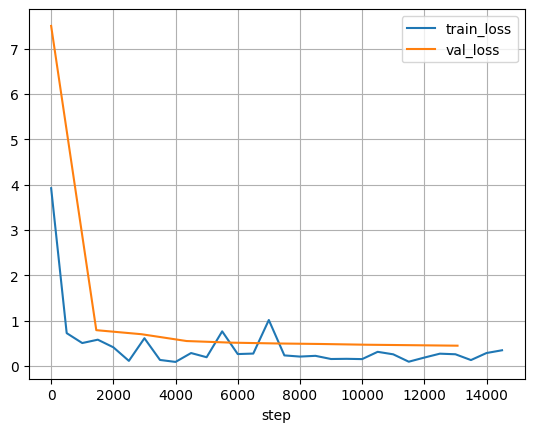

In [90]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    for idx, item in enumerate(train_df.columns):
        plt.plot(train_df.index, train_df[item], label=f"train_{item}")
        plt.plot(val_df.index, val_df[item], label=f"val_{item}")
        plt.grid()
        plt.legend()
        # plt.xticks(range(0, train_df.index[-1], 10*sample_step), range(0, train_df.index[-1], 10*sample_step))
        plt.xlabel("step")

        plt.show()


plot_learning_curves(record, sample_step=500)  #横坐标是 steps

测试集

In [91]:
model.eval()
loss = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}")

loss:     0.4381


### homework3：完成网格搜索学习率实战

pytorch 支持 sklearn 的重参数搜索需要其他的库。一般的项目中设置好命令行脚本后，可以通过更改脚本参数手动实现超参数搜索

In [92]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


准备数据

In [93]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [94]:
from sklearn.model_selection import train_test_split

#拆分训练集和测试集，random_state是随机种子,同样的随机数种子，是为了得到同样的随机值
x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state=11)
# 训练集
print(x_train.shape, y_train.shape)
# 验证集
print(x_valid.shape, y_valid.shape)
# 测试集
print(x_test.shape, y_test.shape)

dataset_maps = {
    "train": [x_train, y_train],
    "valid": [x_valid, y_valid],
    "test": [x_test, y_test],
}

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [95]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler()

构建数据集

In [96]:
from torch.utils.data import Dataset


class HousingDataset(Dataset):
    def __init__(self, mode='train'):
        self.x, self.y = dataset_maps[mode]
        self.x = torch.from_numpy(scaler.transform(self.x)).float()
        self.y = torch.from_numpy(self.y).float().reshape(-1, 1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


train_ds = HousingDataset("train")
valid_ds = HousingDataset("valid")
test_ds = HousingDataset("test")

DataLoader

In [97]:
from torch.utils.data import DataLoader

batch_size = 256  #大一些，可以加快训练速度
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

定义模型

In [98]:
#回归模型我们只需要1个数

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=8):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 30),
            nn.ReLU(),
            nn.Linear(30, 1)
        )

    def forward(self, x):
        # x.shape [batch size, 8]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 1]
        return logits

In [99]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [100]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

    return np.mean(loss_list)

In [101]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()

                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train()

                    # 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [102]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=5):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    for idx, item in enumerate(train_df.columns):
        plt.plot(train_df.index, train_df[item], label=f"train_{item}")
        plt.plot(val_df.index, val_df[item], label=f"val_{item}")
        plt.grid()
        plt.legend()
        # plt.xticks(range(0, train_df.index[-1], 10*sample_step), range(0, train_df.index[-1], 10*sample_step))
        plt.xlabel("step")

        plt.show()

# plot_learning_curves(record)  #横坐标是 steps

网格搜索，for循环实现

  0%|          | 0/4600 [00:00<?, ?it/s]

Early stop at epoch 58 / global_step 2668
lr: 0.01


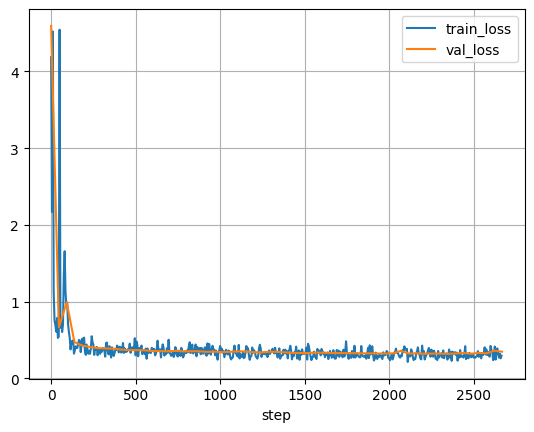

loss:     0.3481


  0%|          | 0/4600 [00:00<?, ?it/s]

Early stop at epoch 73 / global_step 3358
lr: 0.03


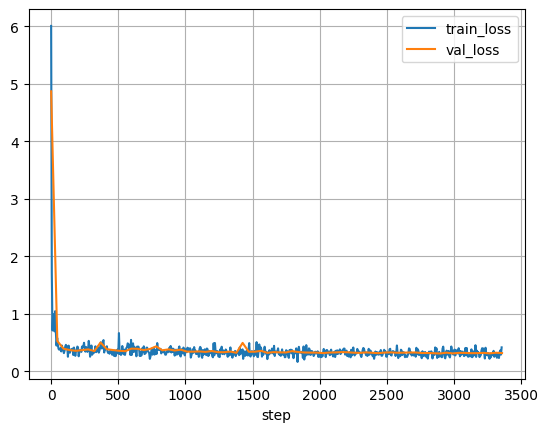

loss:     0.3173


  0%|          | 0/4600 [00:00<?, ?it/s]

Early stop at epoch 9 / global_step 414
lr: 0.3


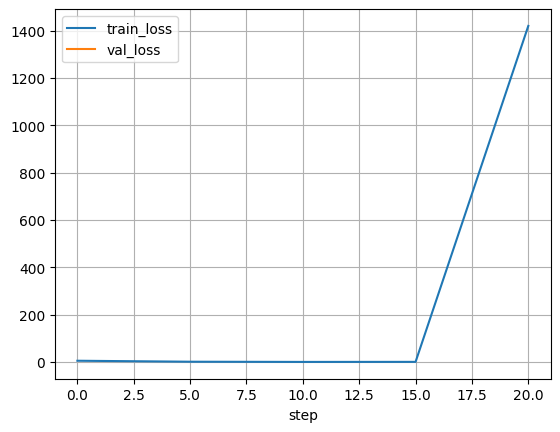

loss:     nan


  0%|          | 0/4600 [00:00<?, ?it/s]

lr: 0.001


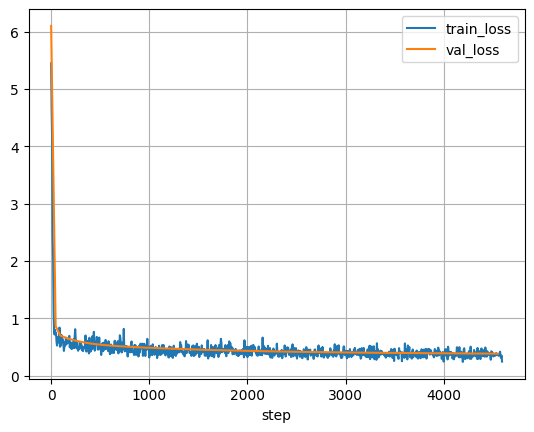

loss:     0.3849


In [103]:
for lr in [1e-2, 3e-2, 3e-1, 1e-3]:
    epoch = 100

    model = NeuralNetwork()

    # 1. 定义损失函数 采用MSE损失
    loss_fct = nn.MSELoss()
    # 2. 定义优化器 采用SGD
    # Optimizers specified in the torch.optim package
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # 3. early stop
    early_stop_callback = EarlyStopCallback(patience=10, min_delta=1e-3)

    model = model.to(device)
    record = training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        early_stop_callback=early_stop_callback,
        eval_step=len(train_loader)
    )
    print("lr: {}".format(lr))
    plot_learning_curves(record)
    model.eval()
    loss = evaluating(model, val_loader, loss_fct)
    print(f"loss:     {loss:.4f}")

### homework4：完成自定义损失，自定义层实战

### homework5：完成多输入，多输出实战